# ROAD LANE LINE DETECTOR:

In [1]:
# Importing dependencies:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
                           
import matplotlib.image as mpimg
import cv2
import os

# Colour Selection:

In [2]:
img = mpimg.imread('test_images/solidWhiteRight.jpg')

In [3]:
# Grab the x and y size and make a copy of the image
ysize = img.shape[0]
xsize = img.shape[1]
color_select = np.copy(img)

In [4]:
# Selecting colours:
red_threshold = 200
green_threshold = 200
blue_threshold = 200

In [5]:
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

In [6]:
# Identifying pixels below threshold:
thresholds = (img[:,:,0] < rgb_threshold[0]) \
            | (img[:,:,1] < rgb_threshold[1]) \
            | (img[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

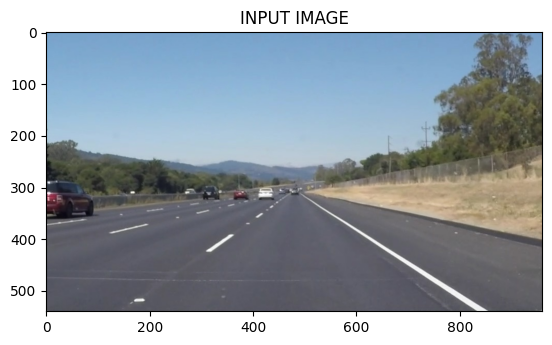

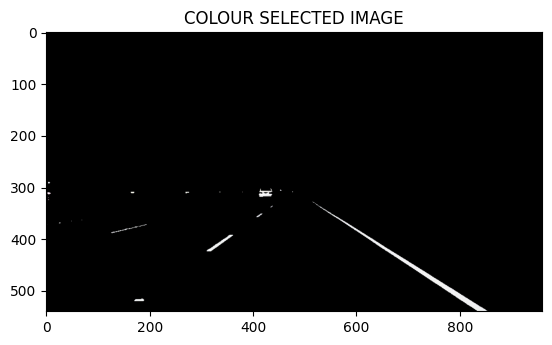

In [7]:
plt.imshow(img)
plt.title("INPUT IMAGE")
plt.show()
plt.imshow(color_select)
plt.title("COLOUR SELECTED IMAGE")
plt.show()

# Region Masking:

In [8]:
img = mpimg.imread('test_images/solidWhiteRight.jpg')

In [9]:
def Lane(img):
    # Grab the x and y size and make a copy of the image
    ysize = img.shape[0]
    xsize = img.shape[1]
    color_select = np.copy(img)
    line_image = np.copy(img)
    
    # Selecting colours:
    red_threshold = 200
    green_threshold = 200
    blue_threshold = 200

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Triangular mask:
    left_bottom = [100, 539]
    right_bottom = [950, 539]
    apex = [480, 290]

    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Identifying pixels below threshold:
    color_thresholds = (img[:,:,0] < rgb_threshold[0]) | \
                        (img[:,:,1] < rgb_threshold[1]) | \
                        (img[:,:,2] < rgb_threshold[2])

    # Region inside the line:
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))

    color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]

    line_image[~color_thresholds & region_thresholds] = [9, 255, 0]

    plt.imshow(img)
    x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
    y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
    plt.plot(x, y, 'r--', lw=4)
    plt.title("REGION OF INTEREST")
    plt.show()
    plt.imshow(color_select)
    plt.title("COLOUR SELECTION IN TRIANGULAR REGION")
    plt.show()
    plt.imshow(line_image)
    plt.title("REGION MASKED IMAGE [LANE LINES IN GREEN]")
    plt.show()

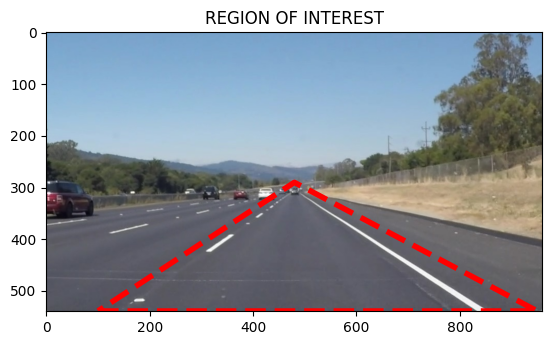

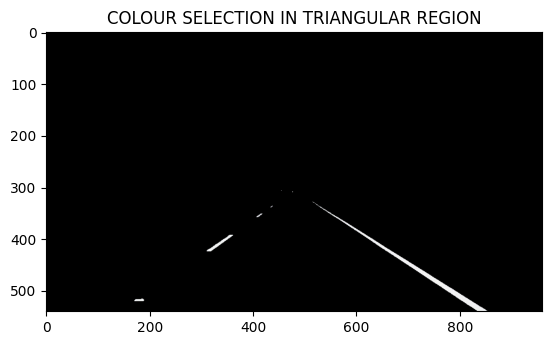

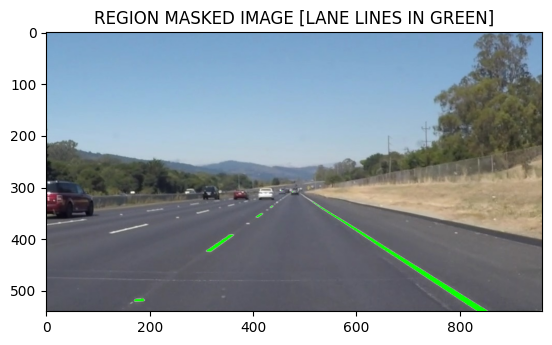

In [10]:
output = Lane(img)

__We can see clearly that the white line has been successfully detected.__

# Testing with another image with Yellow lines:

In [11]:
img = mpimg.imread('test_images/solidYellowLeft.jpg')

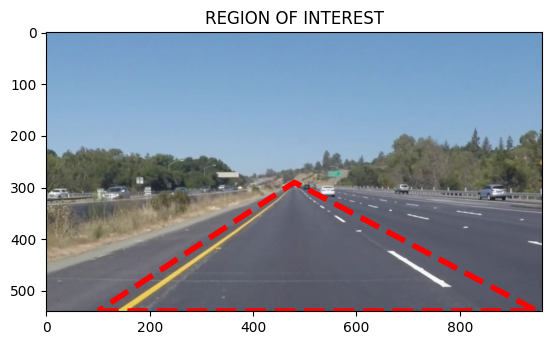

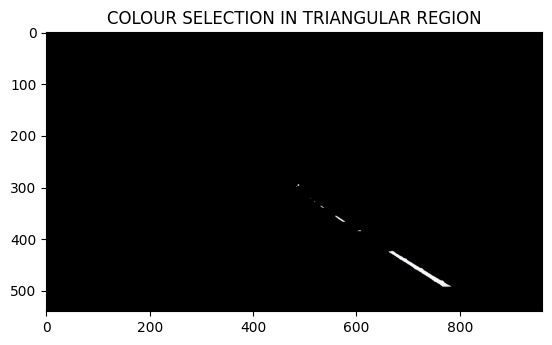

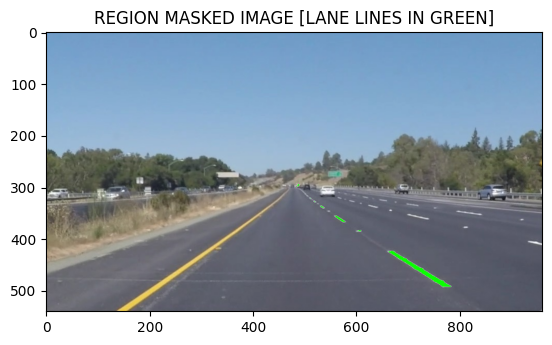

In [12]:
output = Lane(img)

__From the above image, we can notice that though previously white line has been successfully detected, here it fails in the yellow line.  Hence we have to resolve this issue.__

# Canny Edge Detection:

In [13]:
img = mpimg.imread('test_images/solidYellowLeft.jpg')

In [14]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Kernel size for Gaussian smoothing/blurring:
kernel_size = 5 
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

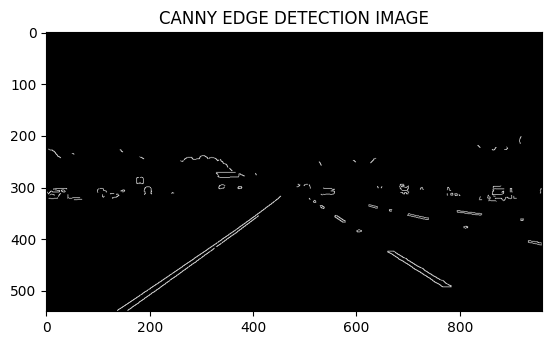

In [15]:
plt.imshow(edges, cmap='Greys_r')
plt.title("CANNY EDGE DETECTION IMAGE")
plt.show()

# Hough Transform and Detecting Lane Lines:

In [16]:
img = mpimg.imread('test_images/solidYellowLeft.jpg')

In [17]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Kernel size for Gaussian smoothing/blurring:
kernel_size = 5 
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

low_threshold = 180
high_threshold = 240
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Masked Edges:
mask = np.zeros_like(edges)   
ignore_mask_color = 255

# Defining a four sided polygon to mask:
imshape = img.shape
vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

rho = 1                              # distance resolution in pixels of the Hough grid
theta = np.pi/180                    # angular resolution in radians of the Hough grid
threshold = 2                        # minimum number of votes (intersections in Hough grid cell)
min_line_length = 4                  # minimum number of pixels making up a line
max_line_gap = 5                     # maximum gap in pixels between connectable line segments
line_image = np.copy(img)*0        # creating a blank to draw lines 

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
                        
# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
        
# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges))

lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
lines_edges = cv2.polylines(lines_edges,vertices, True, (0,0,255), 10)

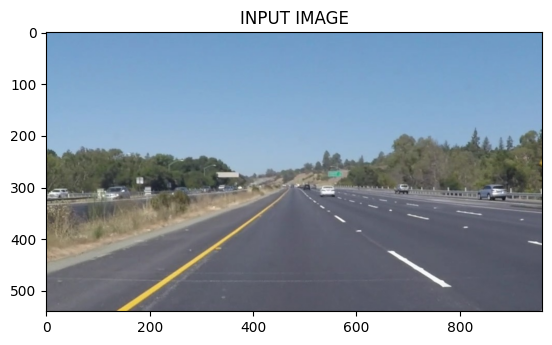

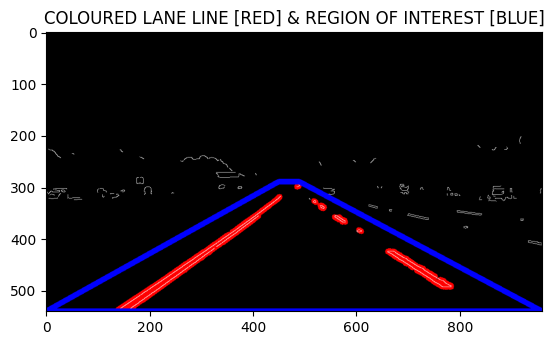

In [18]:
plt.imshow(img)
plt.title("INPUT IMAGE")
plt.show()
plt.imshow(lines_edges)
plt.title("COLOURED LANE LINE [RED] & REGION OF INTEREST [BLUE]")
plt.show()

# Land Detection Pipeline:

In [19]:
# 1.Gray Scale
# 2.Gaussian Smoothing
# 3.Canny Edge Detection
# 4.Region Masking
# 5.Hough Transform
# 6.Draw Lines [Mark Lane Lines with different Color]

In [20]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def slope_lines(image,lines):
    img = image.copy()
    poly_vertices = []
    order = [0,1,3,2]

    left_lines = [] # Like /
    right_lines = [] # Like \
    for line in lines:
        for x1,y1,x2,y2 in line:

            if x1 == x2:
                pass #Vertical Lines
            else:
                m = (y2 - y1) / (x2 - x1)
                c = y1 - m * x1

                if m < 0:
                    left_lines.append((m,c))
                elif m >= 0:
                    right_lines.append((m,c))

    left_line = np.mean(left_lines, axis=0)
    right_line = np.mean(right_lines, axis=0)

    #print(left_line, right_line)

    for slope, intercept in [left_line, right_line]:

        #getting complete height of image in y1
        rows, cols = image.shape[:2]
        y1= int(rows) #image.shape[0]

        #taking y2 upto 60% of actual height or 60% of y1
        y2= int(rows*0.6) #int(0.6*y1)

        #we know that equation of line is y=mx +c so we can write it x=(y-c)/m
        x1=int((y1-intercept)/slope)
        x2=int((y2-intercept)/slope)
        poly_vertices.append((x1, y1))
        poly_vertices.append((x2, y2))
        draw_lines(img, np.array([[[x1,y1,x2,y2]]]))
    
    poly_vertices = [poly_vertices[i] for i in order]
    cv2.fillPoly(img, pts = np.array([poly_vertices],'int32'), color = (0,255,0))
    return cv2.addWeighted(image,0.7,img,0.4,0.)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    line_img = slope_lines(line_img,lines)
    return line_img

def weighted_img(img, initial_img, α=0.1, β=1., γ=0.):
    lines_edges = cv2.addWeighted(initial_img, α, img, β, γ)
    return lines_edges

def get_vertices(image):
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.15, rows]
    top_left     = [cols*0.45, rows*0.6]
    bottom_right = [cols*0.95, rows]
    top_right    = [cols*0.55, rows*0.6] 
    
    ver = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    
    return ver

In [21]:
# Lane finding Pipeline
def lane_finding_pipeline(image):
    
    #Grayscale
    gray_img = grayscale(image)
    #Gaussian Smoothing
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 5)
    #Canny Edge Detection
    canny_img = canny(img = smoothed_img, low_threshold = 180, high_threshold = 240)
    #Masked Image Within a Polygon
    masked_img = region_of_interest(img = canny_img, vertices = get_vertices(image))
    #Hough Transform Lines
    houghed_lines = hough_lines(img = masked_img, rho = 1, theta = np.pi/180, threshold = 20, min_line_len = 20, max_line_gap = 180)
    #Draw lines on edges
    output = weighted_img(img = houghed_lines, initial_img = image, α=0.8, β=1., γ=0.)
    
    return output

# Pipeline Testing:

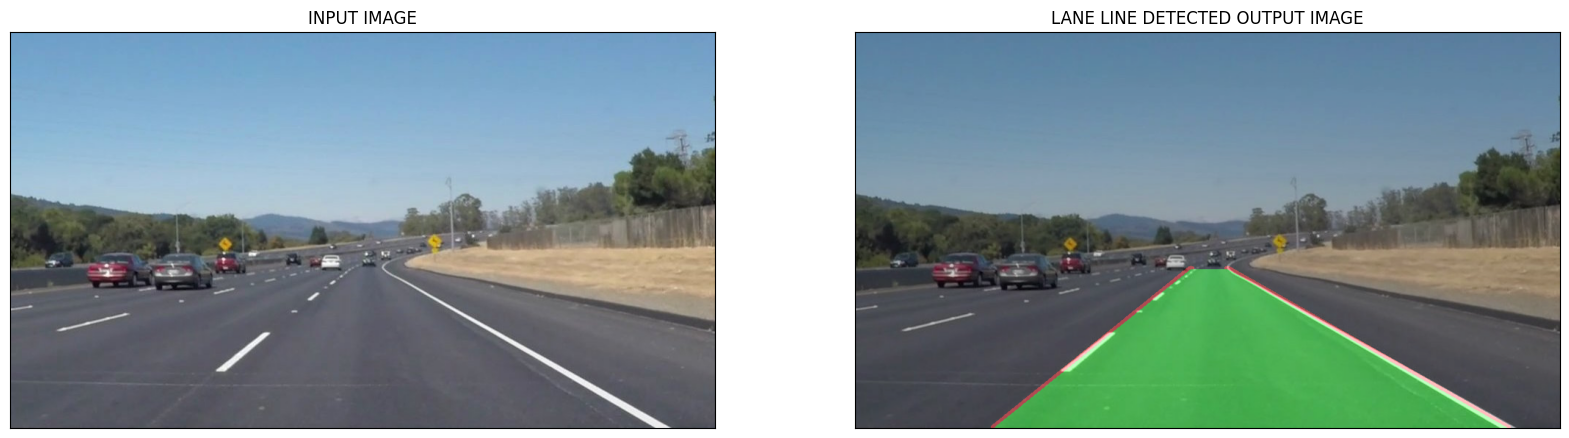

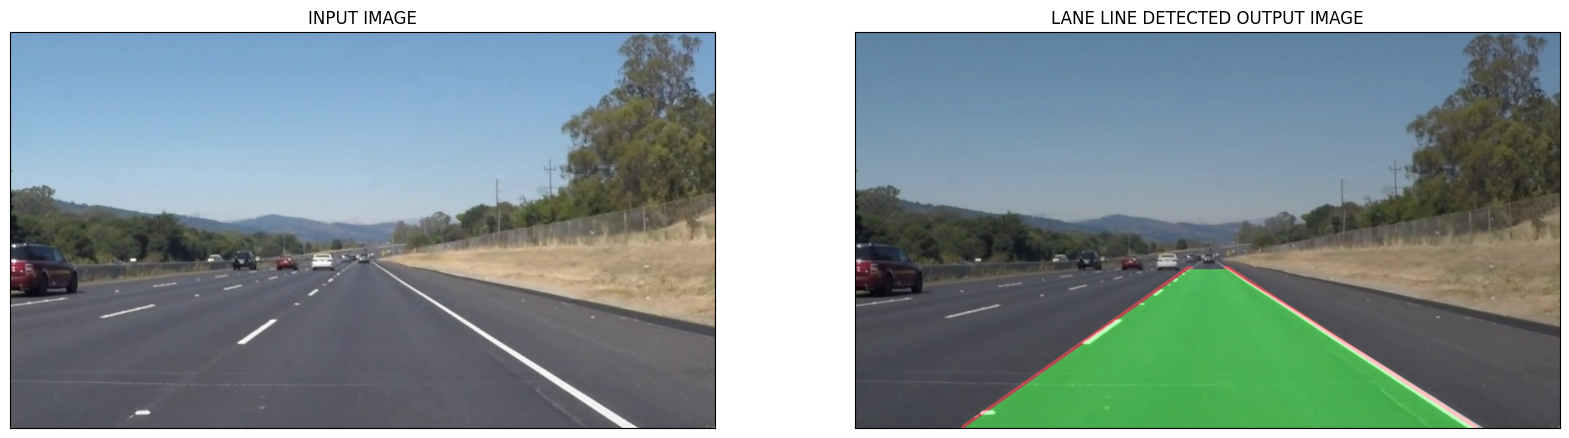

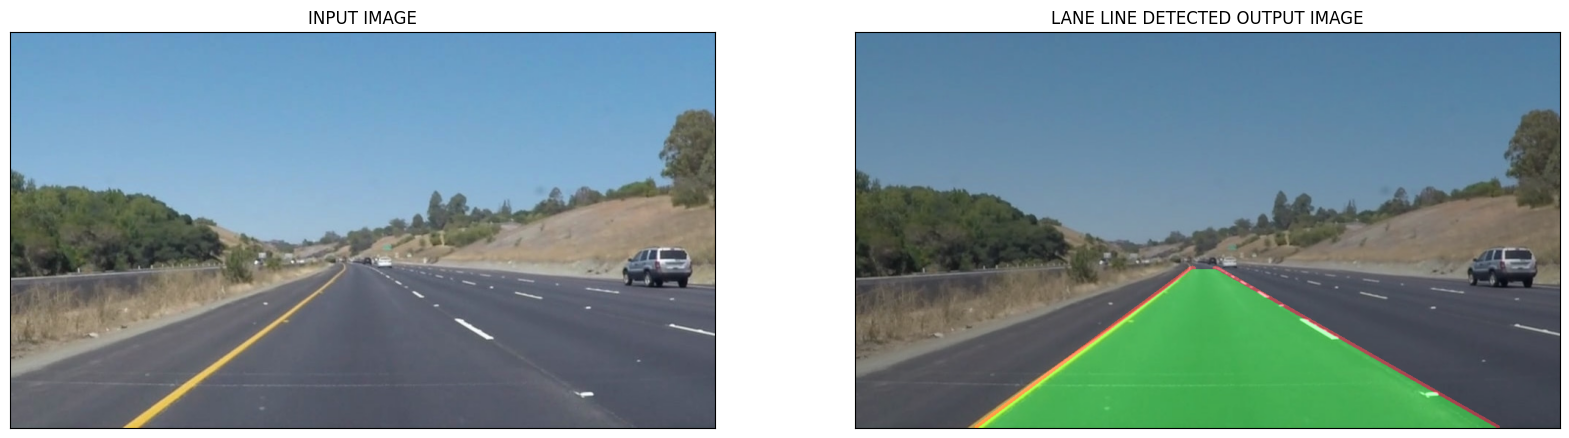

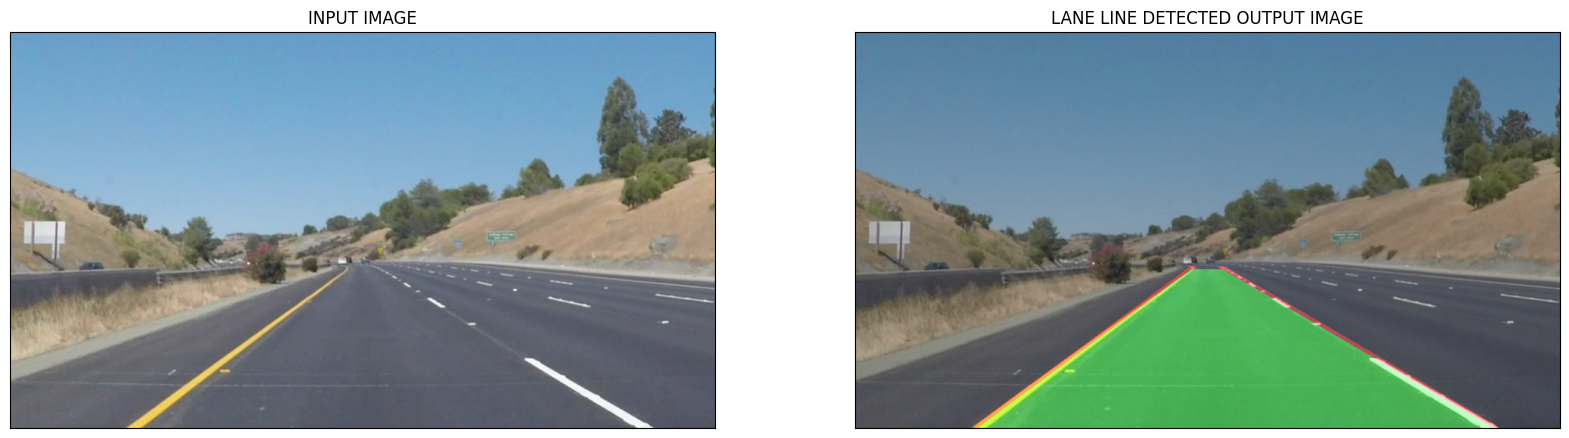

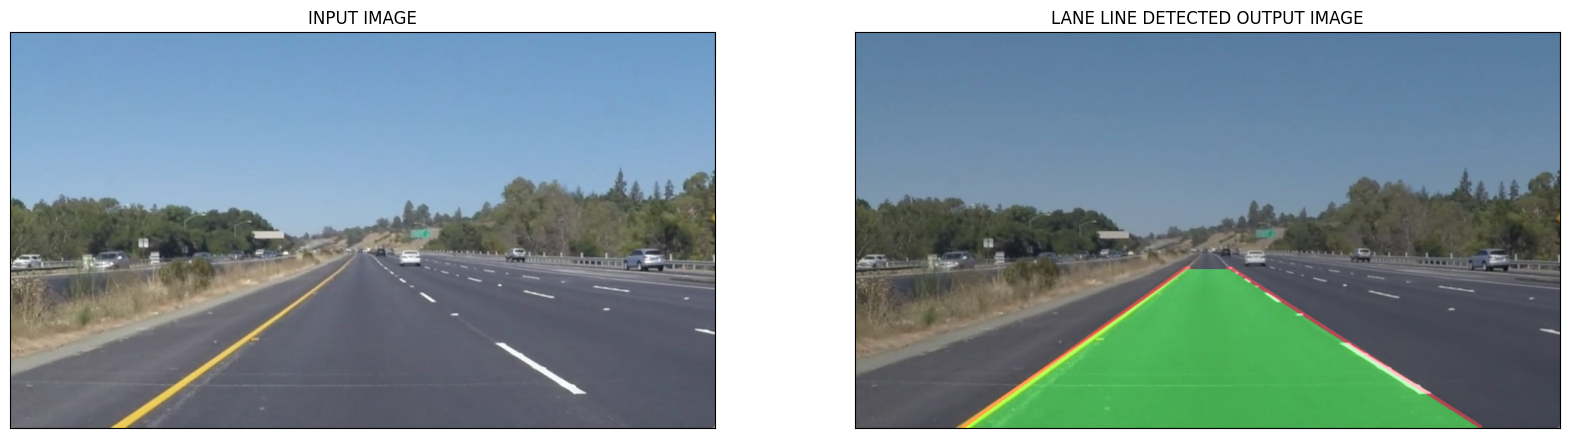

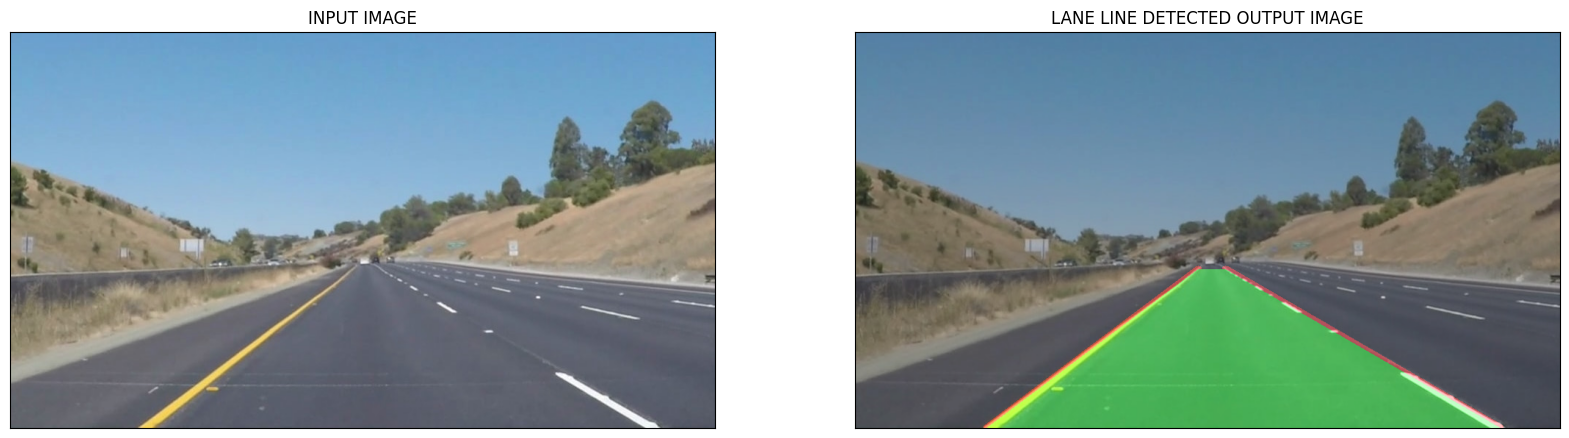

In [22]:
for image_path in list(os.listdir('./test_images')):
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./test_images/{image_path}')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("INPUT IMAGE")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(lane_finding_pipeline(image))
    ax.set_title("LANE LINE DETECTED OUTPUT IMAGE")
    plt.show()

# Real Time Lane Line Detection - White Lane:

In [23]:
#!pip install moviepy

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
white_output = './solidWhiteRight.mp4'

In [26]:
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(lane_finding_pipeline)
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video ./solidWhiteRight.mp4.
Moviepy - Writing video ./solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready ./solidWhiteRight.mp4
CPU times: total: 5.06 s
Wall time: 9.55 s


# WHITE LANE Output video:

In [27]:
HTML("""
<video width="960" height="500" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Real Time Lane Line Detection - Yellow Lane:

In [28]:
yellow_output = './solidYellowLeft.mp4'

In [29]:
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(lane_finding_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video ./solidYellowLeft.mp4.
Moviepy - Writing video ./solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready ./solidYellowLeft.mp4
CPU times: total: 14.6 s
Wall time: 25.6 s


# YELLOW LANE Output video:

In [30]:
HTML("""
<video width="960" height="500" controls>
  <source src="{0}">
</video>
""".format(yellow_output))